In [1]:
import pyspark as ps
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SQLContext
from pyspark.sql import functions as f

spark = ps.sql.SparkSession.builder.master('local') \
    .appName('Project 1').getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [2]:
path = 'nba_2017_pie.csv'
df = sqlContext.read.csv(path, header = True, 
                         quote = '"', sep = ",", 
                         inferSchema = True)
df.show(5)

+-----------------+----+---+---+---+---+----+------+------+------+----+------+---------+-----+-----+----+--------+----+----+----+------+----+
|           PLAYER|TEAM|AGE| GP|  W|  L| MIN|OFFRTG|DEFRTG|NETRTG|AST%|AST/TO|AST RATIO|OREB%|DREB%|REB%|TO RATIO|EFG%| TS%|USG%|  PACE| PIE|
+-----------------+----+---+---+---+---+----+------+------+------+----+------+---------+-----+-----+----+--------+----+----+----+------+----+
|Russell Westbrook| OKC| 28| 81| 46| 35|34.6| 107.9| 104.6|   3.3|54.3|  1.92|     23.4|  5.3| 27.9|16.7|    12.2|47.6|55.4|40.8|102.31|23.0|
| Boban Marjanovic| DET| 28| 35| 16| 19| 8.4| 104.3| 102.4|   1.9| 5.4|   0.9|      5.1| 16.6| 31.3|23.9|     5.7|54.5|60.6|24.8|  97.2|19.6|
|Demetrius Jackson| BOS| 22|  5|  1|  4| 3.4| 124.2| 117.8|   6.3|30.0|   0.0|     31.1|  9.1| 11.8|10.3|     0.0|87.5|75.3|17.2| 87.46|19.4|
|    Anthony Davis| NOP| 24| 75| 31| 44|36.1| 104.2| 102.5|   1.7|11.0|  0.87|      7.3|  6.7| 26.9|17.0|     8.4|51.8|58.0|32.6|100.19|19.2|
|     

In [3]:
df.printSchema()

root
 |-- PLAYER: string (nullable = true)
 |-- TEAM: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- GP: integer (nullable = true)
 |-- W: integer (nullable = true)
 |-- L: integer (nullable = true)
 |-- MIN: double (nullable = true)
 |-- OFFRTG: double (nullable = true)
 |-- DEFRTG: double (nullable = true)
 |-- NETRTG: double (nullable = true)
 |-- AST%: double (nullable = true)
 |-- AST/TO: double (nullable = true)
 |-- AST RATIO: double (nullable = true)
 |-- OREB%: double (nullable = true)
 |-- DREB%: double (nullable = true)
 |-- REB%: double (nullable = true)
 |-- TO RATIO: double (nullable = true)
 |-- EFG%: double (nullable = true)
 |-- TS%: double (nullable = true)
 |-- USG%: double (nullable = true)
 |-- PACE: double (nullable = true)
 |-- PIE: double (nullable = true)



In [4]:
df.count()

486

In [5]:
team_count = df.select('TEAM').distinct().count()
print(team_count)

30


In [6]:
df.select('TEAM').distinct().show(5)

+----+
|TEAM|
+----+
| GSW|
| DET|
| LAL|
| NYK|
| LAC|
+----+
only showing top 5 rows



In [7]:
df_pandas = df.toPandas()

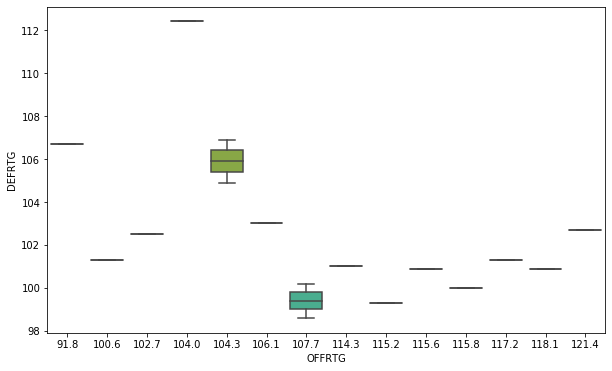

In [8]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'OFFRTG', y = 'DEFRTG', 
            data = df_pandas[df_pandas['TEAM'] == 'GSW'])

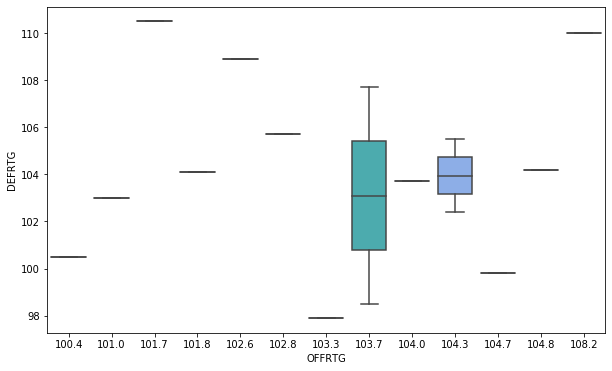

In [9]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'OFFRTG', y = 'DEFRTG', 
            data = df_pandas[df_pandas['TEAM'] == 'DET'])

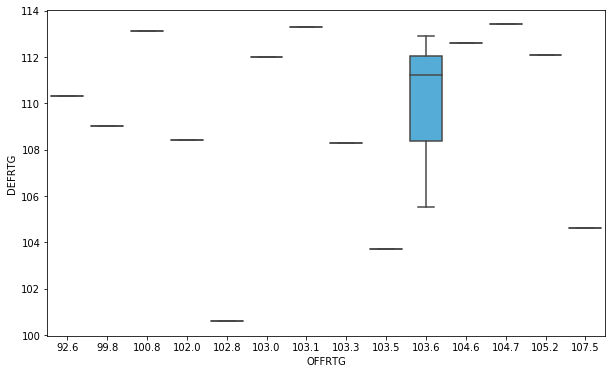

In [10]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'OFFRTG', y = 'DEFRTG', 
            data = df_pandas[df_pandas['TEAM'] == 'LAL'])

In [11]:
overall_performance = df.groupBy('TEAM').sum('OFFRTG', 'DEFRTG')
overall_performance.show(10)

+----+------------------+------------------+
|TEAM|       sum(OFFRTG)|       sum(DEFRTG)|
+----+------------------+------------------+
| GSW|1746.7999999999997|1642.6000000000004|
| DET|1551.3000000000002|            1562.4|
| LAL|1643.6999999999998|1750.9999999999998|
| NYK|1564.2000000000003|1619.9000000000003|
| LAC|            1593.7|1584.9999999999998|
| UTA|1604.7999999999997|1534.3999999999996|
| BOS|            1617.2|1602.3999999999999|
| TOR|            1699.4|            1648.3|
| SAS|1691.2000000000003|            1612.0|
| POR|1475.6000000000001|1490.8999999999996|
+----+------------------+------------------+
only showing top 10 rows



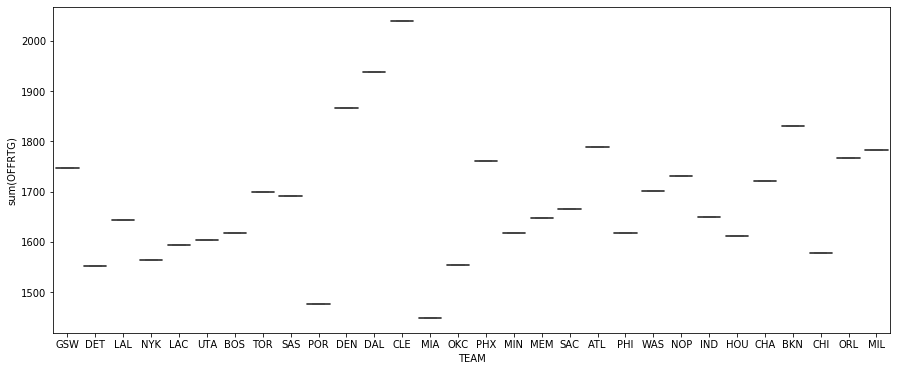

In [12]:
plt.figure(figsize = (15, 6))
sns.boxplot(x = 'TEAM', y = 'sum(OFFRTG)',
            data = overall_performance.toPandas())

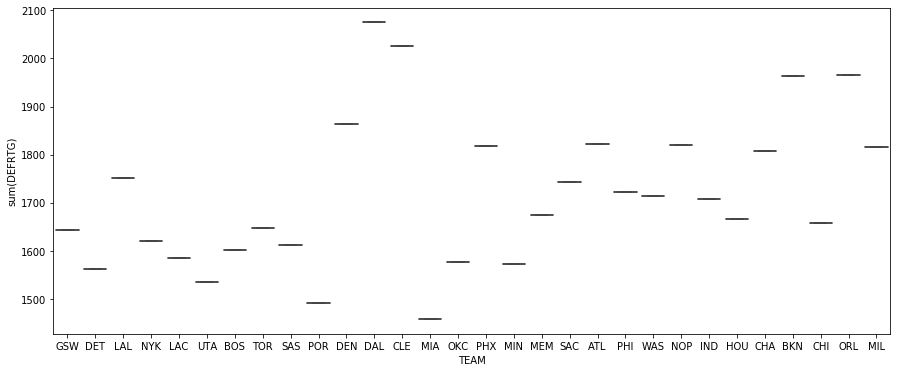

In [13]:
plt.figure(figsize = (15, 6))
sns.boxplot(x = 'TEAM', y = 'sum(DEFRTG)',
            data = overall_performance.toPandas())

In [14]:
from pyspark.sql.types import StructType, \
    StructField, StringType, FloatType

schema = StructType([ \
    StructField('Team_1', StringType(), True), \
    StructField('Team_1_Score', FloatType(), True), \
    StructField('Team_2', StringType(), True), \
    StructField('Team_2_Score', FloatType(), True), \
  ])

In [15]:
teams = overall_performance.select('TEAM').rdd.flatMap(lambda x: x).collect()
OFFRTG = overall_performance.select('sum(OFFRTG)').rdd.flatMap(lambda x: x).collect()
DEFRTG = overall_performance.select('sum(DEFRTG)').rdd.flatMap(lambda x: x).collect()
team1 = []
team2 = []
team1_score = []
team2_score = []
for i in range(len(teams)):
    for j in range(i + 1, len(teams)):
        team1.append(teams[i])
        team2.append(teams[j])
        team1_score.append(OFFRTG[i] + DEFRTG[i])
        team2_score.append(OFFRTG[j] + DEFRTG[j])

In [16]:
data = []
for i in range(len(team1)):
    data.append((team1[i], team1_score[i], team2[i], team2_score[i]))
    
new_df = spark.createDataFrame(data = data, schema = schema)
new_df.show(10)

+------+------------+------+------------+
|Team_1|Team_1_Score|Team_2|Team_2_Score|
+------+------------+------+------------+
|   GSW|      3389.4|   DET|      3113.7|
|   GSW|      3389.4|   LAL|      3394.7|
|   GSW|      3389.4|   NYK|      3184.1|
|   GSW|      3389.4|   LAC|      3178.7|
|   GSW|      3389.4|   UTA|      3139.2|
|   GSW|      3389.4|   BOS|      3219.6|
|   GSW|      3389.4|   TOR|      3347.7|
|   GSW|      3389.4|   SAS|      3303.2|
|   GSW|      3389.4|   POR|      2966.5|
|   GSW|      3389.4|   DEN|      3731.0|
+------+------------+------+------------+
only showing top 10 rows



In [17]:
new_df = new_df.withColumn('Team_1_Win_Likelihood', 
                  (new_df['Team_1_Score'] / (new_df['Team_1_Score'] + new_df['Team_2_Score'])))
new_df.show(10)

+------+------------+------+------------+---------------------+
|Team_1|Team_1_Score|Team_2|Team_2_Score|Team_1_Win_Likelihood|
+------+------------+------+------------+---------------------+
|   GSW|      3389.4|   DET|      3113.7|   0.5211975989814953|
|   GSW|      3389.4|   LAL|      3394.7|  0.49960939513032976|
|   GSW|      3389.4|   NYK|      3184.1|   0.5156157149682437|
|   GSW|      3389.4|   LAC|      3178.7|   0.5160396619907953|
|   GSW|      3389.4|   UTA|      3139.2|   0.5191618578472185|
|   GSW|      3389.4|   BOS|      3219.6|   0.5128461041524814|
|   GSW|      3389.4|   TOR|      3347.7|   0.5030948180767931|
|   GSW|      3389.4|   SAS|      3303.2|   0.5064399635675015|
|   GSW|      3389.4|   POR|      2966.5|   0.5332682947215551|
|   GSW|      3389.4|   DEN|      3731.0|  0.47601257637623634|
+------+------------+------+------------+---------------------+
only showing top 10 rows



In [18]:
new_df = new_df.withColumn('Winner', 
                 f.when(f.col('Team_1_Score') > f.col('Team_2_Score'), \
                        f.col('Team_1')).otherwise(f.col('Team_2')))
new_df.show(10)

+------+------------+------+------------+---------------------+------+
|Team_1|Team_1_Score|Team_2|Team_2_Score|Team_1_Win_Likelihood|Winner|
+------+------------+------+------------+---------------------+------+
|   GSW|      3389.4|   DET|      3113.7|   0.5211975989814953|   GSW|
|   GSW|      3389.4|   LAL|      3394.7|  0.49960939513032976|   LAL|
|   GSW|      3389.4|   NYK|      3184.1|   0.5156157149682437|   GSW|
|   GSW|      3389.4|   LAC|      3178.7|   0.5160396619907953|   GSW|
|   GSW|      3389.4|   UTA|      3139.2|   0.5191618578472185|   GSW|
|   GSW|      3389.4|   BOS|      3219.6|   0.5128461041524814|   GSW|
|   GSW|      3389.4|   TOR|      3347.7|   0.5030948180767931|   GSW|
|   GSW|      3389.4|   SAS|      3303.2|   0.5064399635675015|   GSW|
|   GSW|      3389.4|   POR|      2966.5|   0.5332682947215551|   GSW|
|   GSW|      3389.4|   DEN|      3731.0|  0.47601257637623634|   DEN|
+------+------------+------+------------+---------------------+------+
only s

In [19]:
winning_count = new_df.groupBy('Winner').count().sort(f.col('count').desc())
winning_count.show(15)

+------+-----+
|Winner|count|
+------+-----+
|   CLE|   29|
|   DAL|   28|
|   BKN|   27|
|   ORL|   26|
|   DEN|   25|
|   ATL|   24|
|   MIL|   23|
|   PHX|   22|
|   NOP|   21|
|   CHA|   20|
|   WAS|   19|
|   SAC|   18|
|   LAL|   17|
|   GSW|   16|
|   IND|   15|
+------+-----+
only showing top 15 rows



In [20]:
winning_count = winning_count.withColumn('Most_Matchups_Winning_Likelyhood', 
                                         winning_count['count'] / (team_count - 1))
winning_count.show(15)

+------+-----+--------------------------------+
|Winner|count|Most_Matchups_Winning_Likelyhood|
+------+-----+--------------------------------+
|   CLE|   29|                             1.0|
|   DAL|   28|              0.9655172413793104|
|   BKN|   27|              0.9310344827586207|
|   ORL|   26|               0.896551724137931|
|   DEN|   25|              0.8620689655172413|
|   ATL|   24|              0.8275862068965517|
|   MIL|   23|              0.7931034482758621|
|   PHX|   22|              0.7586206896551724|
|   NOP|   21|              0.7241379310344828|
|   CHA|   20|              0.6896551724137931|
|   WAS|   19|              0.6551724137931034|
|   SAC|   18|              0.6206896551724138|
|   LAL|   17|              0.5862068965517241|
|   GSW|   16|              0.5517241379310345|
|   IND|   15|              0.5172413793103449|
+------+-----+--------------------------------+
only showing top 15 rows

